In [2]:
import numpy as np
import detectron2
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import glob
import pickle
import cv2
import os
import json
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='grade3', ticks=True, grid=False, figsize=(20, 10))

# Get proposals
This only needs to be run once

## pickle format
dictionary: {"boxes":`boxes`, "scores":`scores`}  
boxes:(1000, 32)  
scores:(1000, 9) 8 class + 1 background  

In [11]:
cfg = get_cfg()
# cfg.merge_from_file(r"./output/config.yaml")
cfg.merge_from_file(r"./detectron2/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml")
cfg.MODEL.WEIGHTS = r"./model_final_af9cf5.pkl"
predictor = DefaultPredictor(cfg)
imgpath = glob.glob(r"./datasets/cityscapes/leftImg8bit/val/*/*.png")
gtpath = glob.glob(r"./datasets/cityscapes/gtFine/val/*/*.json")
imgpath.sort()
gtpath.sort()
print(imgpath[0], gtpath[0])

Config './detectron2/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml' has no VERSION. Assuming it to be compatible with latest v2.


./datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png ./datasets/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_polygons.json


In [12]:
# clear proposals folder beforehand
temp = glob.glob(r"./proposals/*.pkl")
for i in temp:
    os.remove(i)

for i in range(500):
    if (i % 100 == 99):
        print("progress: {} / 500".format(i))
    imgName = os.path.splitext(os.path.basename(imgpath[i]))[0]
    img = cv2.imread(imgpath[i])
    output = predictor(img)
    os.rename(r"./proposals/temp.pkl", r"./proposals/" + imgName + r".pkl")


progress: 99 / 500
progress: 199 / 500
progress: 299 / 500
progress: 399 / 500
progress: 499 / 500


## Helper Functions

In [13]:
def print_rect(s, xy, w, h, color):
    plt.gca().add_patch(plt.Rectangle(xy=xy,
    width=w, 
    height=h,
    fill=False, linewidth=1, edgecolor=color))
    plt.text(xy[0], xy[1], s, size = 10, bbox = dict(facecolor = "r", alpha = 0.2))

def area(box):
    return max(0, (box[2] - box[0])) * max(0, (box[3] - box[1]))
    
def iou(box1, box2):
    U = [max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])]
    return area(U) / (area(box1) + area(box2) - area(U) + 1e-6)
    
def pairwise_iou(boxs1, boxs2):
    boxs1 = boxs1.reshape(-1, 4)
    boxs2 = boxs2.reshape(-1, 4)
    out = np.zeros((len(boxs1), len(boxs2)))
    assert(len(boxs1) > 0)
    assert(len(boxs2) > 0)
    for i, box1 in enumerate(boxs1):
        for j, box2 in enumerate(boxs2):
            out[i, j] = iou(box1, box2)
    return out

def index_area_threshold(boxes, area_threshold):
    index = []
    for i, box in enumerate(boxes):
        if area(box) <= area_threshold:
            index.append(i);
    return index

selection = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
label2int = {'person':0, 'rider':1, 'car':2, 'truck':3, 'bus':4, 'train':5, 'motorcycle':6, 'bicycle':7}
proposal_paths = glob.glob("./proposals/*.pkl")
proposal_paths.sort()
print(proposal_paths[0])

./proposals/frankfurt_000000_000294_leftImg8bit.pkl


# Compute Proposal Box Recall & Precision
reference: https://medium.com/@yanfengliux/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef

In [14]:
# optional: load smallscapes
smallscapes = True

if smallscapes:
    gtpath = glob.glob(r"./datasets/smallscapes/*.json")
    gtpath.sort()
    area_threshold = 7000
else:
    gtpath = glob.glob(r"./datasets/cityscapes/gtFine/val/*/*.json")
    gtpath.sort()
    
print(gtpath[0])

./datasets/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_polygons.json


In [ ]:
iou_threshold = 0.5
precisions = [0. for i in range(9)]
recalls = [0. for i in range(9)]

for i in range(500):
    with open(proposal_paths[i], "rb") as file:
        temp = pickle.load(file)
        raw_boxes = temp['boxes'].cpu().reshape(1000, 8, 4)
        raw_scores = temp['scores'].cpu()[:, :-1]
    
    with open(gtpath[i], 'rb') as file:
        data = file.read()
    gts = json.loads(data)["objects"] # list[dict]
    labels = []
    gtboxes = []
    for gt in gts:
        if not gt['label'] in selection:
            continue
        polygon = gt['polygon']
        labels.append(gt['label'])
        gtboxes.append([9999, 9999, 0, 0])
        for point in polygon:
            gtboxes[-1][0] = min(gtboxes[-1][0], point[0])
            gtboxes[-1][1] = min(gtboxes[-1][1], point[1])
            gtboxes[-1][2] = max(gtboxes[-1][2], point[0])
            gtboxes[-1][3] = max(gtboxes[-1][3], point[1])
    gtboxes = np.array(gtboxes)
    labels = [label2int[i] for i in labels]
    raw_pred_classes = raw_scores.argmax(1)
    raw_boxes = np.array([raw_boxes[i, raw_pred_classes[i], :].tolist() for i in range(len(raw_boxes))])
    if smallscapes:
        filt = [area(box) < area_threshold for box in raw_boxes]
        raw_boxes = raw_boxes[filt]
        raw_scores = raw_scores[filt]
        raw_pred_classes = raw_pred_classes[filt]
#     print(raw_boxes.shape, raw_scores.shape, raw_pred_classes.shape)
    
    for j, score_threshold in enumerate(np.arange(0.5, 0.95, 0.05)):
        filt = raw_scores.max(dim=1)[0] > score_threshold
#         print(raw_boxes.shape, filt.shape)
        boxes = raw_boxes[filt]
        scores = raw_scores[filt]
        pred_classes = raw_pred_classes[filt]
#         print(raw_scores)
#         print(len(boxes), len(gtboxes))
        
        # special cases
        if len(boxes) == 0:
            TP_pre, TP_rec, FN, FP = 0, 0, len(gtboxes), 0
            precision = TP_pre / (TP_pre + FP) if TP_pre + FP != 0 else 1
            recall = TP_rec / (TP_rec + FN) if TP_rec + FN != 0 else 1
            precisions[j] += precision
            recalls[j] += recall
            continue
        if len(gtboxes) == 0:
            TP_pre, TP_rec, FN, FP = 0, 0, 0, len(boxes)
            precision = TP_pre / (TP_pre + FP) if TP_pre + FP != 0 else 1
            recall = TP_rec / (TP_rec + FN) if TP_rec + FN != 0 else 1
            precisions[j] += precision
            recalls[j] += recall
            continue

        ious = pairwise_iou(boxes, gtboxes)
        eval_matrix = ious > iou_threshold

#         plt.subplot(1, 9, j+1)
#         plt.imshow(eval_matrix)

        TP_pre, TP_rec = np.sum(np.sum(eval_matrix, axis=1) > 0), np.sum(np.sum(eval_matrix, axis=0) > 0) 
        FN = np.sum(np.sum(eval_matrix, axis=0) == 0)
        FP = np.sum(np.sum(eval_matrix, axis=1) == 0)
        # Precision & Recall
        precision = TP_pre / (TP_pre + FP) if TP_pre + FP != 0 else 1
        recall = TP_rec / (TP_rec + FN) if TP_rec + FN != 0 else 1
        precisions[j] += precision
        recalls[j] += recall

#         img = cv2.imread(imgpath[i])
#         b, g, r = cv2.split(img)
#         img = cv2.merge([r, g, b])
#         plt.imshow(img)
#         for box, pred_class in zip(boxes, pred_classes):
#             print_rect(selection[pred_class], (box[0], box[1]), box[2] - box[0], box[3] - box[1], 'b')
#         for box, label in zip(gtboxes, labels):
#             print_rect(selection[label], (box[0], box[1]), box[2] - box[0], box[3] - box[1], 'r')

    if i % 10 == 9:
        print(f"progress: {i+1} / 500")
for i in range(9):
    recalls[i] /= 500
    precisions[i] /= 500


progress: 10 / 500
progress: 20 / 500


0.1 & 0.2 & 0.3 & 0.4 & 0.5 & 0.6 & 0.7 & 0.8 & 0.9 \\
0.84 & 0.82 & 0.8 & 0.79 & 0.78 & 0.77 & 0.75 & 0.73 & 0.69 \\
0.83 & 0.86 & 0.87 & 0.89 & 0.9 & 0.91 & 0.92 & 0.93 & 0.95 \\


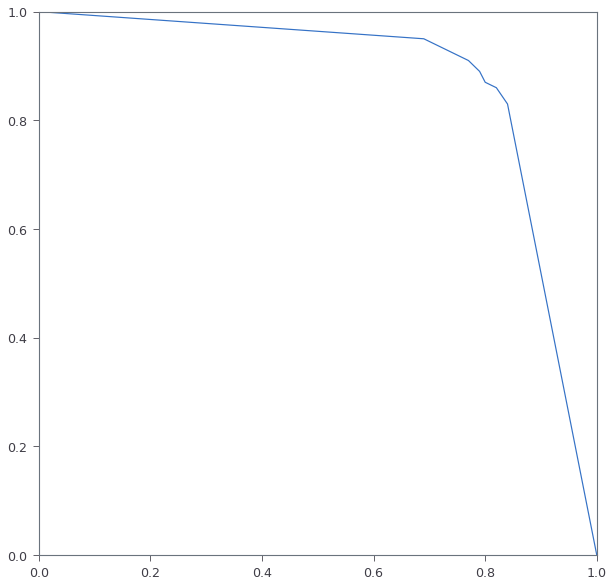

In [31]:
thre = [round(a * 100) / 100 for a in np.arange(0.5, 0.95, 0.05)]
rec = [1] + [round(a * 100) / 100 for a in recalls] + [0]
pre = [0] + [round(a * 100) / 100 for a in precisions] + [1]

print(*thre, sep=' & ', end=' \\\\\n')
print(*rec[1:-1], sep=' & ', end=' \\\\\n')
print(*pre[1:-1], sep=' & ', end=' \\\\\n')

plt.figure(figsize = (10,10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(rec, pre)



# Extract small objects' annotation (smallscapes)

In [6]:
# helper functions
def polygon2box(polygon):
    """Convert polygon to Bounding box
    Args:
        polygon: (N, 2) list or ndarray
    Returns:
        box: (4, ) ndarray
    """
    if type(polygon) != np.ndarray:
        # print(type(polygon))
        polygon = np.array(polygon)
    
    mins, maxs = np.min(polygon, axis=0), np.max(polygon, axis=0)
    box = np.array([mins[0], mins[1], maxs[0], maxs[1]])
    # print(box.dtype)
    return box

        

In [18]:
area_threshold = 6000

# clear destination folder beforehand
temp = glob.glob(r"./datasets/smallscapes/*.json")
for i in temp:
    os.remove(i)
    
for path in gtpath:
    with open(path, 'r') as file:# rb
        data = json.load(file)
    objects = data["objects"] # list[dict]
    out = {'imgHeight': data['imgHeight'], 'imgWidth': data['imgWidth'], 'objects': []} # the same format as cityscapes
    for obj in objects:
        if obj['label'] in selection:
            box = polygon2box(obj['polygon'])
            if area(box) < area_threshold:
                out['objects'].append(obj)
    
    # dump to json !!!OUT CAN BE EMPTY!!!
    base_name = os.path.splitext(os.path.basename(path))[0]
    with open(r'./datasets/smallscapes/' + base_name + r'.json', 'w') as file:
        s = json.dump(out, file, indent=4, separators=(',', ': '))
    
            

# Visualize gtMask

In [7]:
from cityscapesscripts.preparation.json2instanceImg import json2instanceImg
gtpath = glob.glob(r'./datasets/smallscapes/*.json')
print(gtpath[0])
for path in gtpath:
    base_name = os.path.splitext(os.path.basename(path))[0]
    outImg = r'./datasets/smallscapes/' + base_name + r'.png'
    json2instanceImg(path, outImg, encoding="ids") 

./datasets/smallscapes/frankfurt_000000_022254_gtFine_polygons.json


In [33]:
gtmask_path = glob.glob(r'./datasets/smallscapes/*.png')
gtmask_path.sort()
def visualize_gtmask(index):
    masks = cv2.imread(gtmask_path[index])
    img = cv2.imread(imgpath[index])
    sequence = np.unique(masks)[1:]
#     print(sequence)
    new_img = np.zeros_like(img).astype('float64')
    for label in sequence:
        mask = (masks == label)
        new_img += (0.9 * (img + 10) * mask + 0.1 * img) / len(sequence)
    cv2.imwrite(r'./temp.png', new_img)
#         cv2.imshow('a', 0.5 * img * (img == label)  + 0.5 * img)

visualize_gtmask(0)